# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Data

Let's start by getting our clusters and their statistics:

In [3]:
clusters = pd.read_sql_table('cluster_stats', db_url())
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11351575 entries, 0 to 11351574
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   cluster      int64  
 1   isbns        int64  
 2   loc_recs     float64
 3   ol_editions  float64
 4   ol_works     float64
 5   gr_books     float64
 6   gr_works     float64
dtypes: float64(5), int64(2)
memory usage: 606.2 MB


In [25]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [26]:
clusters.describe()

,isbns,loc_recs,ol_editions,ol_works,gr_books,gr_works
count,1.135158e+07,5.267003e+06,1.006651e+07,1.006651e+07,1.096902e+06,1.096902e+06
mean,1.954009e+00,1.067081e+00,1.376585e+00,9.839345e-01,1.494660e+00,1.011167e+00
std,5.444534e+00,6.448727e-01,2.902846e+00,7.049863e-01,3.992835e+00,2.819616e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,7.645000e+03,6.080000e+02,3.760000e+03,8.990000e+02,2.266000e+03,8.500000e+01


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Distributions

Let's look at the distributions of cluster sizes.

In [38]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,isbns,2.0,5944011
1,isbns,1.0,4308618
2,isbns,4.0,528563
3,isbns,3.0,262544
4,isbns,6.0,92377


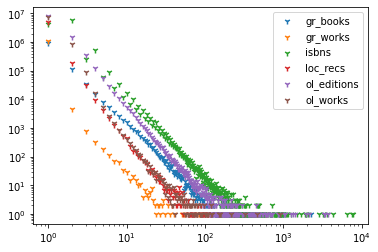

In [54]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xscale('log')
plt.yscale('log')

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [60]:
gr_big = clusters[clusters['gr_works'] > 1].sort_values('gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6319 entries, 100004141 to 414394334
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   isbns        6319 non-null   int64  
 1   loc_recs     5328 non-null   float64
 2   ol_editions  6166 non-null   float64
 3   ol_works     6166 non-null   float64
 4   gr_books     6319 non-null   float64
 5   gr_works     6319 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 345.6 KB


We have 6K of these clusters. What fraction of the GoodReads-affected clusters is this?

In [61]:
len(gr_big) / clusters['gr_books'].count()

0.0057607698773454695

Less than 1%. Not bad, but let's look.

In [63]:
gr_big.head()

,isbns,loc_recs,ol_editions,ol_works,gr_books,gr_works
cluster,,,,,,
100004141,7645,608.0,3317.0,458.0,2266.0,85.0
100066430,3599,404.0,1939.0,321.0,883.0,78.0
100307111,163,4.0,91.0,74.0,60.0,56.0
100162584,327,67.0,266.0,72.0,80.0,54.0
100468456,140,1.0,51.0,18.0,53.0,51.0


What's that big cluster?

In [72]:
biggest = gr_big.index[0]
cluster_titles = pd.read_sql(f'''
    SELECT DISTINCT gr_work_id, work_title
    FROM gr.book_cluster
    JOIN gr.book_ids USING (gr_book_id)
    JOIN gr.work_titles USING (gr_work_id)
    WHERE cluster = {biggest} AND work_title IS NOT NULL;
''', db_url())
cluster_titles

,gr_work_id,work_title
0,145554,The Oxford Bookworms Library Stage 1 Best-sell...
1,674438,The Walrus and the Carpenter
2,789261,"Dracula, Longman Annotated Novel (Longman Anno..."
3,798741,Sleeping Beauty
4,879016,"York Notes on ""Dracula"" (York Notes Advanced)"
5,983168,The Complete Cheapskate: How to Get Out of Deb...
6,1112418,Vingt Mille Lieues Sous les Mers
7,1313599,A Little Princess
8,1411202,The Merry Adventures of Robin Hood
9,1483780,The House of the Seven Gables


Let's also find out how many *ratings* are affected by this.

In [74]:
pd.read_sql('''
    SELECT SUM((gr_works > 1)::int), AVG((gr_works > 1)::int)
    FROM gr.add_action
    JOIN gr.cluster_stats ON (book_id = cluster)
''', db_url())

,sum,avg
0,16852459,0.089189


Almost 9% of our add-to-shelf actions are for such a book - that's disappointing.

### Deep Dive

What do the records causing this look like?

In [76]:
bc_recs = pd.concat([
    pd.read_sql(f'''
        SELECT isbn, 'LOC' AS source, rec_id AS record, title
        FROM locmds.book_rec_isbn
        JOIN isbn_id USING (isbn_id)
        JOIN isbn_cluster USING (isbn_id)
        LEFT JOIN locmds.book_title USING (rec_id)
        WHERE cluster = {biggest}
    ''', db_url()),
    pd.read_sql(f'''
        SELECT isbn, 'OL' AS source, book_code AS record, title
        FROM ol.isbn_link
        JOIN isbn_id USING (isbn_id)
        JOIN isbn_cluster USING (isbn_id)
        LEFT JOIN ol.edition_title USING (edition_id)
        WHERE cluster = {biggest}
    ''', db_url()),
    pd.read_sql(f'''
        SELECT isbn, 'GR' AS source, gr_book_id AS record, work_title
        FROM gr.book_isbn
        JOIN isbn_id USING (isbn_id)
        JOIN isbn_cluster USING (isbn_id)
        JOIN gr.book_ids USING (gr_book_id)
        LEFT JOIN gr.work_titles USING (gr_work_id)
        WHERE cluster = {biggest}
    ''', db_url())
], ignore_index=True)
bc_recs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10489 entries, 0 to 10488
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   isbn        10489 non-null  object
 1   source      10489 non-null  object
 2   record      10489 non-null  int64 
 3   title       6438 non-null   object
 4   work_title  3886 non-null   object
dtypes: int64(1), object(4)
memory usage: 409.9+ KB


In [87]:
bc_recs = bc_recs.drop_duplicates().sort_values('isbn')

In [88]:
bc_recs

,isbn,source,record,title,work_title
5375,0001004735,OL,107018071,Alice in Wonderland (Classics Book & Tape),NaN
4132,0001848259,OL,101883944,"20,000 Leagues Under the Sea",NaN
6229,0003708853,OL,111403047,Dracula,NaN
5145,0004214072,OL,112077510,Little Women.,NaN
6059,0004214501,OL,107018071,Alice in Wonderland,NaN
...,...,...,...,...,...
4023,9998392802,OL,113233063,Through the Looking Glass,NaN
4685,9998556643,OL,111403047,Dracula,NaN
3399,9998651174,OL,104240114,Tom Sawyer,NaN
5581,9998708710,OL,112077510,Little Women (Adventure Classics),NaN
